<h1>Data Science Final Project (Main Model)</h1>
<h3>Muhammad Daffa Rudiyanto 26002104783</h3>

<h3>Setup</h3>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import transformers
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.utils.data import TensorDataset, Dataset, DataLoader
from transformers import BertTokenizer, BertModel


In [2]:
SEED = 4
random.seed(SEED)
np.random.seed(SEED)

def seed_torch(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)# if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


device = 'cuda' if cuda.is_available() else 'cpu'
device

seed_torch(4)

<h3>Data Preprocessing</h3>

In [3]:
df = pd.read_csv(r"MuhammadDaffaRudiyanto_animedataset.csv")
print(len(df))
df.head()

25581


,Title,Synopsis,Status,Genres,Type,Studios,Members,Reviewer,Ratings,Score
0,A A B C,Music video for the song A A B C by Mieko Hiro...,Finished Airing,"Music, Kids",Music,NaN,73,NaN,G - All Ages,NaN
1,A Ben Mao,NaN,Finished Airing,Kids,TV,NaN,153,NaN,PG - Children,NaN
2,A Brightening Life,"Above ground, there are many people, coming an...",Finished Airing,"Drama, Music",Movie,NaN,510,234.0,PG - Children,5.50
3,A Cappella Samurai: Harmony-tai wa Edo wo Sukuu,NaN,Currently Airing,"Comedy, Historical, Music",ONA,NaN,99,NaN,PG-13 - Teens 13 or older,NaN
4,A Christmas Song,Music video for A Christmas Song by Monkey Maj...,Finished Airing,Music,Music,NaN,519,273.0,G - All Ages,5.55


In [4]:
#Check number of missing value
missing_values = df.isna().sum()
rows_with_missing_value = df.isna().any(axis=1).sum()

print(missing_values)
print("Numbers of rows with at least one missing data:", rows_with_missing_value)

Title           0
Synopsis     4677
Status          0
Genres        128
Type            0
Studios     10693
Members         0
Reviewer     9186
Ratings       542
Score        9186
dtype: int64
Numbers of rows with at least one missing data: 13341


In [5]:
# rows_with_empty_values = df[df[['Studios', 'Score']].isna().all(axis=1)].shape[0]

# print("Number of data points with empty values in all specified columns:", rows_with_empty_values)

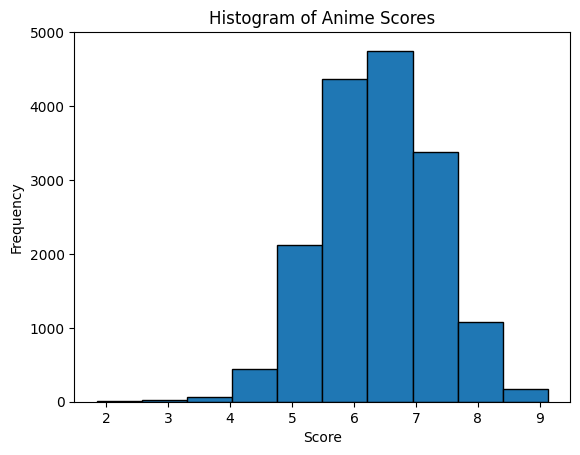

In [6]:
plt.hist(df['Score'], bins=10, edgecolor='black')
plt.title('Histogram of Anime Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.ylim(0, 5000)
plt.show()

In [7]:
# Dropping rows with NaN values in specific columns
df = df.dropna(subset=['Score', 'Synopsis', 'Genres', 'Ratings', 'Studios'])

# Filtering out specific categories and values
df = df[~df['Type'].isin(['Music', 'Special', 'Unknown']) &
        (df['Ratings'] != "Rx - Hentai") &
        ~df['Status'].isin(["Currently Airing", "Not yet aired"])]

df['Members'] = df['Members'].astype(float)

# df = df.drop(['Title', 'Status'], axis=1)
bins = [0, 5, 7, float('inf')]  # Start bins from 0
labels = [0, 1, 2]  # Labels for the bins
df['bins_score'] = pd.cut(df['Score'], bins=bins, labels=labels, right=False)
df['bins_score'] = df['bins_score'].astype(float)

print(len(df))

8910


In [8]:
missing_values = df.isna().sum()
print(missing_values)

Title         0
Synopsis      0
Status        0
Genres        0
Type          0
Studios       0
Members       0
Reviewer      0
Ratings       0
Score         0
bins_score    0
dtype: int64


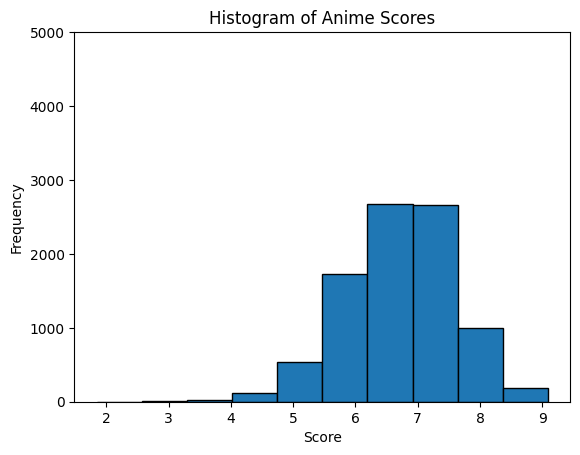

In [9]:
plt.hist(df['Score'], bins=10, edgecolor='black')
plt.title('Histogram of Anime Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.ylim(0, 5000)
plt.show()

In [10]:
df = df.reset_index(drop=True)

In [11]:
df['bins_score'].value_counts()

1.0    5095
2.0    3579
0.0     236
Name: bins_score, dtype: int64

In [12]:
df = df.sample(frac=1, random_state=SEED)
df = df.reset_index(drop=True)
df.head()

,Title,Synopsis,Status,Genres,Type,Studios,Members,Reviewer,Ratings,Score,bins_score
0,Kiznaiver,Katsuhira Agata is a quiet and reserved teenag...,Finished Airing,"Drama, Romance, Sci-Fi",TV,Trigger,730875.0,353836.0,PG-13 - Teens 13 or older,7.37,2.0
1,Haikyuu!! Tokushuu! Haru-kou Volley ni Kaketa ...,The OVA episode revisits the primary matches f...,Finished Airing,"Sports, School, Team Sports, Shounen",OVA,Production I.G,37726.0,11717.0,PG-13 - Teens 13 or older,7.52,2.0
2,Wagamama High Spec,The adorable girls of Ousui Academy's student ...,Finished Airing,"Comedy, School",TV,AXsiZ,33275.0,13785.0,PG-13 - Teens 13 or older,5.38,1.0
3,M3: Sono Kuroki Hagane,"In a dark void known as the Lightless Realm, a...",Finished Airing,"Action, Drama, Mystery, Sci-Fi, Mecha, Psychol...",TV,"Satelight, C2C",56435.0,18694.0,R - 17+ (violence & profanity),6.57,1.0
4,Casshern: Robot Hunter,"In the near future, robot technology has advan...",Finished Airing,"Adventure, Sci-Fi, Mecha",OVA,Tatsunoko Production,8766.0,3376.0,PG-13 - Teens 13 or older,6.31,1.0


<h3>Machine Learning</h3>

In [13]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True)

# Transform Synopsis into a sparse matriax
synopsis_list = vectorizer.fit_transform(df['Synopsis'])

# Process Genres, Studios, Type, and Ratings
# Convert them to sparse matrices after getting dummies
genres_list = csr_matrix(df['Genres'].str.get_dummies(sep=', '))
studios_list = csr_matrix(df['Studios'].str.get_dummies(sep=', '))
type_encoded = csr_matrix(pd.get_dummies(df['Type'], prefix='Type')).astype('float32')
ratings_encoded = csr_matrix(pd.get_dummies(df['Ratings'], prefix='Ratings')).astype('float32')

# Combine everything into a single sparse matrix
X = hstack([synopsis_list, genres_list, studios_list, type_encoded, ratings_encoded])

# Target variable
y = df['Score']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED, stratify = df['bins_score'])
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [15]:
ml_model = SVR(kernel='rbf', verbose=True)
ml_model.fit(X_train, y_train)

# Predictions
predictions = ml_model.predict(X_test)

[LibSVM]

In [16]:
# Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error: %.3f" % mse)

# Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error: %.3f" % rmse)

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error: %.3f" % mae)


Mean Squared Error: 0.309
Root Mean Squared Error: 0.556
Mean Absolute Error: 0.418


<h3>Deep Learning Part 1: Fine-tuning BERT for Synopsis</h3>

In [17]:
# @title
# # MAX_LEN = 200
# MAX_LEN = 512
# TRAIN_BATCH_SIZE = 8
# VALID_BATCH_SIZE = 8
# EPOCHS = 10
# LEARNING_RATE = 1e-05
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',  do_lower_case=True)

In [18]:
# @title
# class CustomDataset(Dataset):

#     def __init__(self, dataframe, tokenizer, max_len):
#         self.tokenizer = tokenizer
#         self.data = dataframe
#         self.Synopsis = dataframe.Synopsis
#         self.targets = self.data.Score
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.Synopsis)

#     def __getitem__(self, index):
#         Synopsis = str(self.Synopsis[index])
#         Synopsis = " ".join(Synopsis.split())

#         inputs = self.tokenizer.encode_plus(
#             Synopsis,
#             None,
#             add_special_tokens=True,
#             max_length=self.max_len,
#             pad_to_max_length=True,
#             return_token_type_ids=True
#         )
#         ids = inputs['input_ids']
#         mask = inputs['attention_mask']
#         token_type_ids = inputs["token_type_ids"]


#         return {
#             'ids': torch.tensor(ids, dtype=torch.long),
#             'mask': torch.tensor(mask, dtype=torch.long),
#             'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
#             'targets': torch.tensor(self.targets[index], dtype=torch.float)
#         }

In [19]:
# @title
# new_df = df.loc[:, ['Synopsis', 'Score']]
# new_df = new_df.reset_index(drop=True)

In [20]:
# @title
# # Creating the dataset and dataloader for the neural network

# # Define the size of the training set
# train_size = 0.8

# # Perform a stratified split to maintain the distribution of 'bins_score' in both sets
# train_dataset, test_dataset = train_test_split(new_df, train_size=train_size, stratify=df['bins_score'], random_state=SEED)

# # Reset index for both datasets
# train_dataset = train_dataset.reset_index(drop=True)
# test_dataset = test_dataset.reset_index(drop=True)


# print("FULL Dataset: {}".format(new_df.shape))
# print("TRAIN Dataset: {}".format(train_dataset.shape))
# print("TEST Dataset: {}".format(test_dataset.shape))

# training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
# testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

In [21]:
# @title
# train_params = {'batch_size': TRAIN_BATCH_SIZE,
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# test_params = {'batch_size': VALID_BATCH_SIZE,
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# training_loader = DataLoader(training_set, **train_params)
# testing_loader = DataLoader(testing_set, **test_params)

In [22]:
# @title
# # Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

# class BERTClass(torch.nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
#         self.l2 = torch.nn.Dropout(0.3)
#         self.l3 = torch.nn.Linear(768, 1)  # Output a single continuous value

#     def forward(self, ids, mask, token_type_ids):
#         _, output_1= self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
#         output = self.l3(output_2)
#         return output

# model = BERTClass()
# model.to(device)

In [23]:
# @title
# def loss_fn(outputs, targets):
#     return torch.nn.MSELoss()(outputs.view(-1), targets.view(-1))  # Mean Squared Error Loss
# optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [24]:
# @title
# def train(epoch):
#     model.train()
#     fin_targets_train = []
#     fin_outputs_train = []
#     for _, data in enumerate(training_loader, 0):
#         ids = data['ids'].to(device, dtype=torch.long)
#         mask = data['mask'].to(device, dtype=torch.long)
#         token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
#         targets = data['targets'].to(device, dtype=torch.float)

#         outputs = model(ids, mask, token_type_ids)

#         optimizer.zero_grad()
#         loss = loss_fn(outputs, targets)

#         fin_targets_train.extend(targets.cpu().detach().numpy().tolist())
#         fin_outputs_train.extend(outputs.cpu().detach().numpy().tolist())

#         if _ % 5000 == 0:
#             print(f'Epoch: {epoch}, Loss:  {loss.item()}')

#         loss.backward()
#         optimizer.step()

#     return fin_outputs_train, fin_targets_train

# def validation(epoch):
#     model.eval()
#     fin_targets = []
#     fin_outputs = []
#     with torch.no_grad():
#         for _, data in enumerate(testing_loader, 0):
#             ids = data['ids'].to(device, dtype=torch.long)
#             mask = data['mask'].to(device, dtype=torch.long)
#             token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
#             targets = data['targets'].to(device, dtype=torch.float)

#             outputs = model(ids, mask, token_type_ids)
#             fin_targets.extend(targets.cpu().detach().numpy().tolist())
#             fin_outputs.extend(outputs.cpu().detach().numpy().tolist())

#     return fin_outputs, fin_targets

In [25]:
# @title
# # Main training and validation loop
# for epoch in range(EPOCHS):
#     outputs_train, targets_train = train(epoch)
#     outputs_train = np.squeeze(outputs_train)  # Convert outputs to a 1D array

#     # Calculate and print training metrics
#     # mse_train = mean_squared_error(targets_train, outputs_train)
#     mae_train = mean_absolute_error(targets_train, outputs_train)
#     # print(f"Epoch {epoch} - Training Mean Squared Error: {mse_train}")
#     print(f"Epoch {epoch} - Training Mean Absolute Error: {mae_train}")

#     # Validate the model
#     outputs, targets = validation(epoch)
#     outputs = np.squeeze(outputs)  # Convert outputs to a 1D array for regression metrics

#     # Calculate and print validation metrics
#     # mse = mean_squared_error(targets, outputs)
#     mae = mean_absolute_error(targets, outputs)
#     # r2 = r2_score(targets, outputs)
#     # print(f"Epoch {epoch} - Validation Mean Squared Error: {mse}")
#     print(f"Epoch {epoch} - Validation Mean Absolute Error: {mae}")
#     # print(f"Epoch {epoch} - R-Squared: {r2}")

In [26]:
# @title
# torch.save(model.state_dict(), 'fine_tuned_bert_model_3.pth')

<h3>Deep Learning Part 2.1: Extract Embeddings from Fine-tuned BERT Model</h3>

In [68]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        output = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        pooled_output = output[1]  # This is the embedding
        return pooled_output  # Return just the embedding



In [28]:
# # Load the model
# bert_model = BERTClass()
# bert_model.load_state_dict(torch.load('fine_tuned_bert_model_final_truncation.pth'))
# bert_model.to(device)

# # Set to evaluation mode for inference
# bert_model.eval()

In [69]:
from google.colab import drive
drive.mount('/content/drive')
# Load the model
bert_model = BERTClass()

# Update this path to the location of your model in Google Drive
model_path = '/content/drive/My Drive/fine_tuned_bert_model_final_truncation_freeze_nostratify.pth'

bert_model.load_state_dict(torch.load(model_path))
bert_model.to(device)

# Set to evaluation mode for inference
bert_model.eval()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [70]:
def generate_bert_embeddings(data_loader, model):
    model.eval()  # Make sure the model is in evaluation mode
    embeddings = []
    with torch.no_grad():
        for _, data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)

            embedding = model(ids, mask, token_type_ids)
            embeddings.append(embedding.cpu().numpy())

    return np.vstack(embeddings)

In [71]:
# Assuming 'df' is your DataFrame and it has a column named 'Synopsis'
synopses = df['Synopsis'].tolist()  # Convert the column to a list

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [72]:
class SynopsesEmbeddingDataset(Dataset):
    def __init__(self, synopses_series, tokenizer, max_len):
        self.tokenizer = tokenizer
        # self.data = dataframe
        # self.Synopsis = dataframe.Synopsis
        self.synopses = synopses_series
        self.max_len = max_len

    def __len__(self):
        return len(self.synopses)

    def __getitem__(self, index):
        synopsis = str(self.synopses.iloc[index])
        synopsis = " ".join(synopsis.split())

        inputs = self.tokenizer.encode_plus(
            synopsis,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation = True
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        }

In [73]:
# Creating the dataset and dataloader
synopses_dataset = SynopsesEmbeddingDataset(df['Synopsis'], tokenizer, max_len=512)
synopses_data_loader = DataLoader(synopses_dataset, batch_size=32, shuffle=False)

synopsis_embeddings = generate_bert_embeddings(synopses_data_loader, bert_model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<h3>Deep Learning Part 2.2: Combine with other features (Genres, Studios, Rating, and Type)</h3>

In [74]:
# Your existing code for processing features
genres_list_dl = df['Genres'].str.get_dummies(sep=', ')
studios_list_dl = df['Studios'].str.get_dummies(sep=', ')
type_encoded_dl = pd.get_dummies(df['Type'], prefix='Type')
ratings_encoded_dl = pd.get_dummies(df['Ratings'], prefix='Ratings')

other_features_df = pd.concat([genres_list_dl, studios_list_dl, type_encoded_dl, ratings_encoded_dl], axis=1)
other_features = other_features_df.values.astype('float32')

In [75]:
combined_features = np.concatenate((synopsis_embeddings, other_features), axis=1)

In [76]:
X_dl = combined_features
y_dl = df['Score'].values.astype('float32')

In [77]:
# X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, train_size=0.8, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, train_size=0.8, random_state=SEED, stratify = df['bins_score'])

In [78]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [79]:
# Creating datasets for DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [80]:
# # Data Loaders
# train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

def _init_fn(worker_id):
    np.random.seed(int(SEED))

train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True, worker_init_fn=_init_fn)
test_loader = DataLoader(dataset=test_dataset, batch_size=10, shuffle=False, worker_init_fn=_init_fn)

In [87]:
# Model definition
seed_torch(4)
class RegressionModel(nn.Module): # defines a new class RegressionModel which is a subclass of nn.Module, the base class for all neural network modules in PyTorch. This is a standard way to create a new neural network in PyTorch.
    def __init__(self, input_size): # constructor method
        super(RegressionModel, self).__init__() # initializes the superclass (nn.Module) from which RegressionModel is derived
        self.fc1 = nn.Linear(input_size, 64) # a fully connected (linear) layer with input_size neurons as input and 64 neurons as output
        self.relu = nn.ReLU() # a ReLU activation function to establish non-linearity to the model, which allows it to learn more complex relationships.
        self.fc2 = nn.Linear(64, 32) # another fully connected layer that takes 64 inputs (the output of the previous layer) and outputs to 32 neurons
        self.fc3 = nn.Linear(32, 1) # final fully connected layer takes 32 inputs and reduces it to a single output since this is a regression problem

    def forward(self, x): #defines the forward pass of the network
        x = self.relu(self.fc1(x)) # the input x is passed through the first linear layer (fc1) and then through the ReLU activation function. The result is then stored back in x.
        x = self.relu(self.fc2(x)) # output of the previous step (now in x) is passed through the second linear layer (fc2) and again through the ReLU function.
        x = self.fc3(x) # the output from the last step is passed through the third linear layer (fc3)
        return x # returns the final output

regression_model = RegressionModel(X_train.shape[1])
regression_model.to(device)  # Move the model to the specified device


RegressionModel(
  (fc1): Linear(in_features=1621, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [88]:
# Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(regression_model.parameters())

In [89]:
# Lists to store metrics
training_mae_list = []
validation_mae_list = []

def train_regression(epoch):
    regression_model.train()
    fin_targets_train = []
    fin_outputs_train = []
    for i, data in enumerate(train_loader, 0):
        X_batch, y_batch = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = regression_model(X_batch)
        loss = criterion(outputs, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()

        fin_targets_train.extend(y_batch.cpu().detach().numpy().tolist())
        fin_outputs_train.extend(outputs.cpu().detach().numpy().tolist())

        if i % 5000 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

    return fin_outputs_train, fin_targets_train

def validation_regression(epoch):
    regression_model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for data in test_loader:
            X_batch, y_batch = data[0].to(device), data[1].to(device)

            outputs = regression_model(X_batch)
            fin_targets.extend(y_batch.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets


In [90]:
# Main training and validation loop
for epoch in range(65):
    outputs_train, targets_train = train_regression(epoch)
    outputs_train = np.squeeze(outputs_train)  # Convert outputs to a 1D array for regression metrics
    mae_train = mean_absolute_error(outputs_train, targets_train)
    training_mae_list.append(mae_train)
    # print(f'Epoch [{epoch+1}/100], Training Mean Absolute Error: {mae_train}')
    print(f'Training Mean Absolute Error: {mae_train}')

    # Validate the model
    outputs, targets = validation_regression(epoch)
    validation_mae = mean_absolute_error(outputs, targets)
    validation_mae_list.append(validation_mae)
    print(f'Validation Mean Absolute Error: {validation_mae}\n')
    outputs = np.squeeze(outputs)  # Convert outputs to a 1D array for regression metrics

Epoch: 0, Loss:  6.565289497375488
Training Mean Absolute Error: 0.43737488052275714
Validation Mean Absolute Error: 0.29742597262599785

Epoch: 1, Loss:  0.21372094750404358
Training Mean Absolute Error: 0.31872444784668025
Validation Mean Absolute Error: 0.28777331093746406

Epoch: 2, Loss:  0.25187990069389343
Training Mean Absolute Error: 0.30745961648379644
Validation Mean Absolute Error: 0.4018505272506731

Epoch: 3, Loss:  0.5839707255363464
Training Mean Absolute Error: 0.306111118491785
Validation Mean Absolute Error: 0.28743201728354134

Epoch: 4, Loss:  0.2552731931209564
Training Mean Absolute Error: 0.30361539648906416
Validation Mean Absolute Error: 0.31226558704033713

Epoch: 5, Loss:  0.3392186164855957
Training Mean Absolute Error: 0.3002685133355234
Validation Mean Absolute Error: 0.38341727722373475

Epoch: 6, Loss:  0.3162743151187897
Training Mean Absolute Error: 0.29862679276870424
Validation Mean Absolute Error: 0.2862093649327956

Epoch: 7, Loss:  0.135292202234

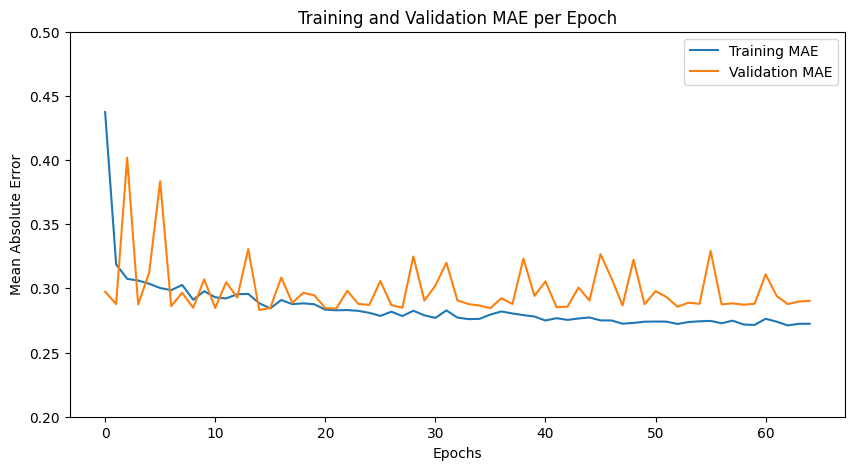

In [91]:
import matplotlib.pyplot as plt

# Plotting the metrics
plt.figure(figsize=(10, 5))
plt.plot(training_mae_list, label='Training MAE')
plt.plot(validation_mae_list, label='Validation MAE')
plt.title('Training and Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.ylim(0.2, 0.5)
plt.legend()
plt.show()

In [ ]:
# @title
# # Training loop
# for epoch in range(60):
#     total_loss = 0
#     fin_targets_train = []
#     fin_outputs_train = []
#     for i, data in enumerate(train_loader, 0):
#         # Move data to device
#         X_batch, y_batch = data[0].to(device), data[1].to(device)

#         optimizer.zero_grad()
#         outputs = regression_model(X_batch)
#         loss = criterion(outputs, y_batch.view(-1, 1))
#         loss.backward()
#         optimizer.step()

#         fin_targets_train.extend(y_batch.cpu().detach().numpy().tolist())
#         fin_outputs_train.extend(outputs.cpu().detach().numpy().tolist())

#     # Calculate and print training MAE
#     mae_train = mean_absolute_error(fin_targets_train, fin_outputs_train)
#     print(f'Epoch [{epoch+1}/100], Training Mean Absolute Error: {mae_train}')


In [ ]:
# @title
# # Evaluation
# regression_model.eval()
# fin_targets = []
# fin_outputs = []
# with torch.no_grad():
#     for data in test_loader:
#         # Move data to device
#         X_batch, y_batch = data[0].to(device), data[1].to(device)

#         outputs = regression_model(X_batch)
#         fin_targets.extend(y_batch.cpu().detach().numpy().tolist())
#         fin_outputs.extend(outputs.cpu().detach().numpy().tolist())

#     # Calculate and print validation MAE
#     mae = mean_absolute_error(fin_targets, fin_outputs)
#     print(f'Validation Mean Absolute Error: {mae}')